In [2]:
# install Jupyter dependencies
!pip install pandas seaborn biopython pyarrow wget tqdm

In [3]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.compute as pc
import pyarrow.dataset as ds
import math
import re
import datetime
from tqdm import tqdm

## Analysis of Canonical Peptides

The parquet files for the canonical peptides including the GCA proteins and GRCh38 can be downloaded from: 
http://ftp.pride.ebi.ac.uk/pub/databases/pride/resources/proteomes/proteogenomics/noncanonical-tissues-2023/PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet 


In [4]:
import wget
import os
if not os.path.isfile('PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet'):
    wget.download('http://ftp.pride.ebi.ac.uk/pub/databases/pride/resources/proteomes/proteogenomics/noncanonical-tissues-2023/PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet')

In [5]:
parq_file = "PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet"
table = pq.read_table(parq_file)
original_df = table.to_pandas()

In [6]:
original_df

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,is_decoy,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names
0,GAGGAGSGGCCCCVLGWLGVALCGLALLSGLVLGLLVGR,[DECOY_GCA_315848],[115],[153],0.383534,1,[10|11|12|13|23-UNIMOD:4],182368.1280,4,958.501276,...,1,['OpenMS:Target-decoy PSM q-value': 0.00704929...,NaN,01524_A01_P015424_S00_N01_R1,12179,None,None,NaN,None,None
1,EYLGAICSCTCFGGQR,[GCA_131462],[2311],[2326],0.000556,1,[7|9|11-UNIMOD:4],200494.1280,2,939.900626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00366430...,NaN,01524_A01_P015424_S00_N01_R1,14522,None,None,NaN,None,None
2,TCVADESAENCDK,"[GRCh38_78290, GCA_14814, CONTAMINANT_P02768-1...","[76, 76, 76, 76]","[88, 88, 88, 88]",0.000556,0,[2|11-UNIMOD:4],83191.5960,2,749.796626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00383706...,NaN,01524_A01_P015424_S00_N01_R1,4604,None,None,NaN,None,None
3,AAAFEEQENETVVVK,[GRCh38_64703],[2494],[2508],0.000556,1,None,158287.7040,2,832.412626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00106247...,NaN,01524_A01_P015424_S00_N01_R1,9826,None,None,NaN,None,None
4,KVADALTNAVAHVDDMPNALSALSDLHAHK,"[GRCh38_28602, GCA_72537]","[62, 62]","[91, 91]",0.000556,0,[8|18-UNIMOD:7],4640.3813,6,522.103821,...,0,['OpenMS:Target-decoy PSM q-value': 0.00055787...,NaN,01524_A01_P015424_S00_N01_R1,27647,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294594,YFEITEEPPYIHFLNTFTSK,"[GRCh38_46198, GCA_99552]","[294, 294]","[313, 313]",0.000556,0,None,5652.1924,3,826.076477,...,0,['OpenMS:Target-decoy PSM q-value': 2.65999930...,NaN,01307_D05_P013386_S00_N36_R1,43638,None,None,NaN,None,None
16294595,SGKLDAFLVLEQLR,"[GRCh38_7521, GCA_100434, GCA_246681]","[687, 687, 687]","[700, 700, 700]",0.000556,0,None,5012.8022,3,530.308350,...,0,['OpenMS:Target-decoy PSM q-value': 0.00012527...,NaN,01307_D05_P013386_S00_N36_R1,38274,None,None,NaN,None,None
16294596,QVYEEEYGSSLEDDVVGDTSGYYQR,"[GRCh38_32181, GCA_15045]","[127, 127]","[151, 151]",0.000556,0,None,4054.3008,3,963.751770,...,0,['OpenMS:Target-decoy PSM q-value': 1.82972572...,NaN,01307_D05_P013386_S00_N36_R1,30154,None,None,NaN,None,None
16294597,LTRPGSSYFNLNPFEVLQIDPEVTDEEIK,"[GRCh38_25113, GCA_58373]","[46, 46]","[74, 74]",0.000556,0,None,6023.4970,3,1117.563232,...,0,['OpenMS:Target-decoy PSM q-value': 0.00108037...,NaN,01307_D05_P013386_S00_N36_R1,46678,None,None,NaN,None,None


In [7]:
print('Number of PSMs in the file = ', len(original_df))

Number of PSMs in the file =  16294599


In [8]:
## Add sample accessions, **NOTE it will work only for LFQ experiments**
sdrf = pd.read_csv("PXD010154.sdrf.tsv", sep = "\t")
sdrf = sdrf[['source name', 'comment[data file]']]
sdrf.rename(columns={"comment[data file]": "reference_file_name", "source name": "sample_id"}, inplace=True)
sdrf['reference_file_name'] = sdrf['reference_file_name'].str.replace('.raw', '', regex=False)
sdrf


,sample_id,reference_file_name
0,PXD010154-V122,01524_A01_P015424_S00_N01_R1
1,PXD010154-V122,01524_B01_P015424_S00_N02_R1
2,PXD010154-V122,01524_C01_P015424_S00_N03_R1
3,PXD010154-V122,01524_D01_P015424_S00_N04_R1
4,PXD010154-V122,01524_E01_P015424_S00_N05_R1
...,...,...
1362,PXD010154-V200,01307_H04_P013386_S00_N32_R1
1363,PXD010154-V200,01307_A05_P013386_S00_N33_R1
1364,PXD010154-V200,01307_B05_P013386_S00_N34_R1
1365,PXD010154-V200,01307_C05_P013386_S00_N35_R1


In [9]:
#Convert array values in the accession to list
def join_vals(x):
    return ','.join(x.astype(str).tolist())

original_df['protein_accessions'] = original_df['protein_accessions'].apply(join_vals)
original_df

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,is_decoy,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names
0,GAGGAGSGGCCCCVLGWLGVALCGLALLSGLVLGLLVGR,DECOY_GCA_315848,[115],[153],0.383534,1,[10|11|12|13|23-UNIMOD:4],182368.1280,4,958.501276,...,1,['OpenMS:Target-decoy PSM q-value': 0.00704929...,NaN,01524_A01_P015424_S00_N01_R1,12179,None,None,NaN,None,None
1,EYLGAICSCTCFGGQR,GCA_131462,[2311],[2326],0.000556,1,[7|9|11-UNIMOD:4],200494.1280,2,939.900626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00366430...,NaN,01524_A01_P015424_S00_N01_R1,14522,None,None,NaN,None,None
2,TCVADESAENCDK,"GRCh38_78290,GCA_14814,CONTAMINANT_P02768-1,CO...","[76, 76, 76, 76]","[88, 88, 88, 88]",0.000556,0,[2|11-UNIMOD:4],83191.5960,2,749.796626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00383706...,NaN,01524_A01_P015424_S00_N01_R1,4604,None,None,NaN,None,None
3,AAAFEEQENETVVVK,GRCh38_64703,[2494],[2508],0.000556,1,None,158287.7040,2,832.412626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00106247...,NaN,01524_A01_P015424_S00_N01_R1,9826,None,None,NaN,None,None
4,KVADALTNAVAHVDDMPNALSALSDLHAHK,"GRCh38_28602,GCA_72537","[62, 62]","[91, 91]",0.000556,0,[8|18-UNIMOD:7],4640.3813,6,522.103821,...,0,['OpenMS:Target-decoy PSM q-value': 0.00055787...,NaN,01524_A01_P015424_S00_N01_R1,27647,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294594,YFEITEEPPYIHFLNTFTSK,"GRCh38_46198,GCA_99552","[294, 294]","[313, 313]",0.000556,0,None,5652.1924,3,826.076477,...,0,['OpenMS:Target-decoy PSM q-value': 2.65999930...,NaN,01307_D05_P013386_S00_N36_R1,43638,None,None,NaN,None,None
16294595,SGKLDAFLVLEQLR,"GRCh38_7521,GCA_100434,GCA_246681","[687, 687, 687]","[700, 700, 700]",0.000556,0,None,5012.8022,3,530.308350,...,0,['OpenMS:Target-decoy PSM q-value': 0.00012527...,NaN,01307_D05_P013386_S00_N36_R1,38274,None,None,NaN,None,None
16294596,QVYEEEYGSSLEDDVVGDTSGYYQR,"GRCh38_32181,GCA_15045","[127, 127]","[151, 151]",0.000556,0,None,4054.3008,3,963.751770,...,0,['OpenMS:Target-decoy PSM q-value': 1.82972572...,NaN,01307_D05_P013386_S00_N36_R1,30154,None,None,NaN,None,None
16294597,LTRPGSSYFNLNPFEVLQIDPEVTDEEIK,"GRCh38_25113,GCA_58373","[46, 46]","[74, 74]",0.000556,0,None,6023.4970,3,1117.563232,...,0,['OpenMS:Target-decoy PSM q-value': 0.00108037...,NaN,01307_D05_P013386_S00_N36_R1,46678,None,None,NaN,None,None


#### Blast GCA with canonical

In this step, we need to take all the PSMs from the search and blast them against canonical databases including ENSEMBL protein database and Uniprot proteomes. This step is important because some non-canonical peptides may be identified in the GCA proteins but they also are found in reference databases. 


In [10]:
# Download the reference databases. 
import gzip, shutil

ensembl_db = "https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/pep/Homo_sapiens.GRCh38.pep.all.fa.gz"
if not os.path.isfile("Homo_sapiens.GRCh38.pep.all.fa"):
   wget.download(ensembl_db)
   with gzip.open("Homo_sapiens.GRCh38.pep.all.fa.gz", 'r') as f_in, open('Homo_sapiens.GRCh38.pep.all.fa', 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)

uniprot_db = "https://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/reference_proteomes/Eukaryota/UP000005640/UP000005640_9606_additional.fasta.gz"
if not os.path.isfile("UP000005640_9606_additional.fasta"):
   wget.download(uniprot_db)
   with gzip.open("UP000005640_9606_additional.fasta.gz", 'r') as f_in, open('UP000005640_9606_additional.fasta', 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)


In [11]:
fa_set = set()
for j in SeqIO.parse("Homo_sapiens.GRCh38.pep.all.fa", "fasta"):
    fa_set.add(str(j.seq))
for j in SeqIO.parse("UP000005640_9606_additional.fasta", "fasta"):
    fa_set.add(str(j.seq))


In [12]:
def blast_with_canonical_fasta(peptide):
    for fasta in fa_set:
        if peptide in fasta:
            return "GRCh38"
    return "GCA"

In [19]:
import ahocorasick
start_time = datetime.datetime.now()
print(start_time)

seq_set = set(original_df["sequence"].to_list())

auto = ahocorasick.Automaton()
seq_dict = dict()
for seq_peptide in seq_set:
    auto.add_word(seq_peptide, seq_peptide)
    seq_dict[seq_peptide] = "GCA"

auto.make_automaton()

for protein_seq in tqdm(fa_set):
    for end_ind, found in auto.iter(protein_seq):
        seq_dict[found]= "GRCh38"

end_time = datetime.datetime.now()
print("End time :", end_time)
set_time_taken = end_time - start_time
print("Time consumption :", set_time_taken)

print("GCA: {}".format(sum(1 for v in seq_dict.values() if v == "GCA")))
print("GRCh38: {}".format(sum(1 for v in seq_dict.values() if v == "GRCh38")))


2023-11-13 14:19:03.752565


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104154/104154 [00:19<00:00, 5422.05it/s]

End time : 2023-11-13 14:19:31.250610
Time consumption : 0:00:27.498045
GCA: 92613
GRCh38: 416227


In [20]:
#shorten accessions to save memory
def get_source(accessions):
    accessions = accessions.split(',')

    for acc in accessions:
        if acc.startswith('DECOY_CONTAMINANT'):
            return 'DECOY_CONTAMINANT'
    for acc in accessions:
        if acc.startswith('CONTAMINANT'):
            return 'CONTAMINANT'
    
    for acc in accessions:
        if acc.startswith('DECOY_GRCh38'):
            return 'DECOY_GRCh38'
    
    for acc in accessions:
        if acc.startswith('DECOY_GCA'):
            return 'DECOY_GCA'

    for acc in accessions:
        if acc.startswith('GRCh38'):
            return 'GRCh38'
    
    for acc in accessions:
        if acc.startswith('GCA'):
            return 'GCA'
    
    return accessions

In [21]:
original_df['prot_source'] = original_df['protein_accessions'].apply(get_source)

In [22]:
original_df['prot_source'] = original_df.apply(lambda x: seq_dict.get(x['sequence']) if x['prot_source'] == 'GCA' else x['prot_source'], axis=1)

In [24]:
original_df['prot_source'].value_counts()

prot_source
GRCh38               15353338
CONTAMINANT            606683
GCA                    173244
DECOY_GCA              107166
DECOY_GRCh38            53107
DECOY_CONTAMINANT        1061
Name: count, dtype: int64

/var/folders/r_/b2xtff5d3j3c3tn51td6lxwx19cbq9/T/ipykernel_43499/1184045292.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gca['posterior_error_probability'],
/var/folders/r_/b2xtff5d3j3c3tn51td6lxwx19cbq9/T/ipykernel_43499/1184045292.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gr

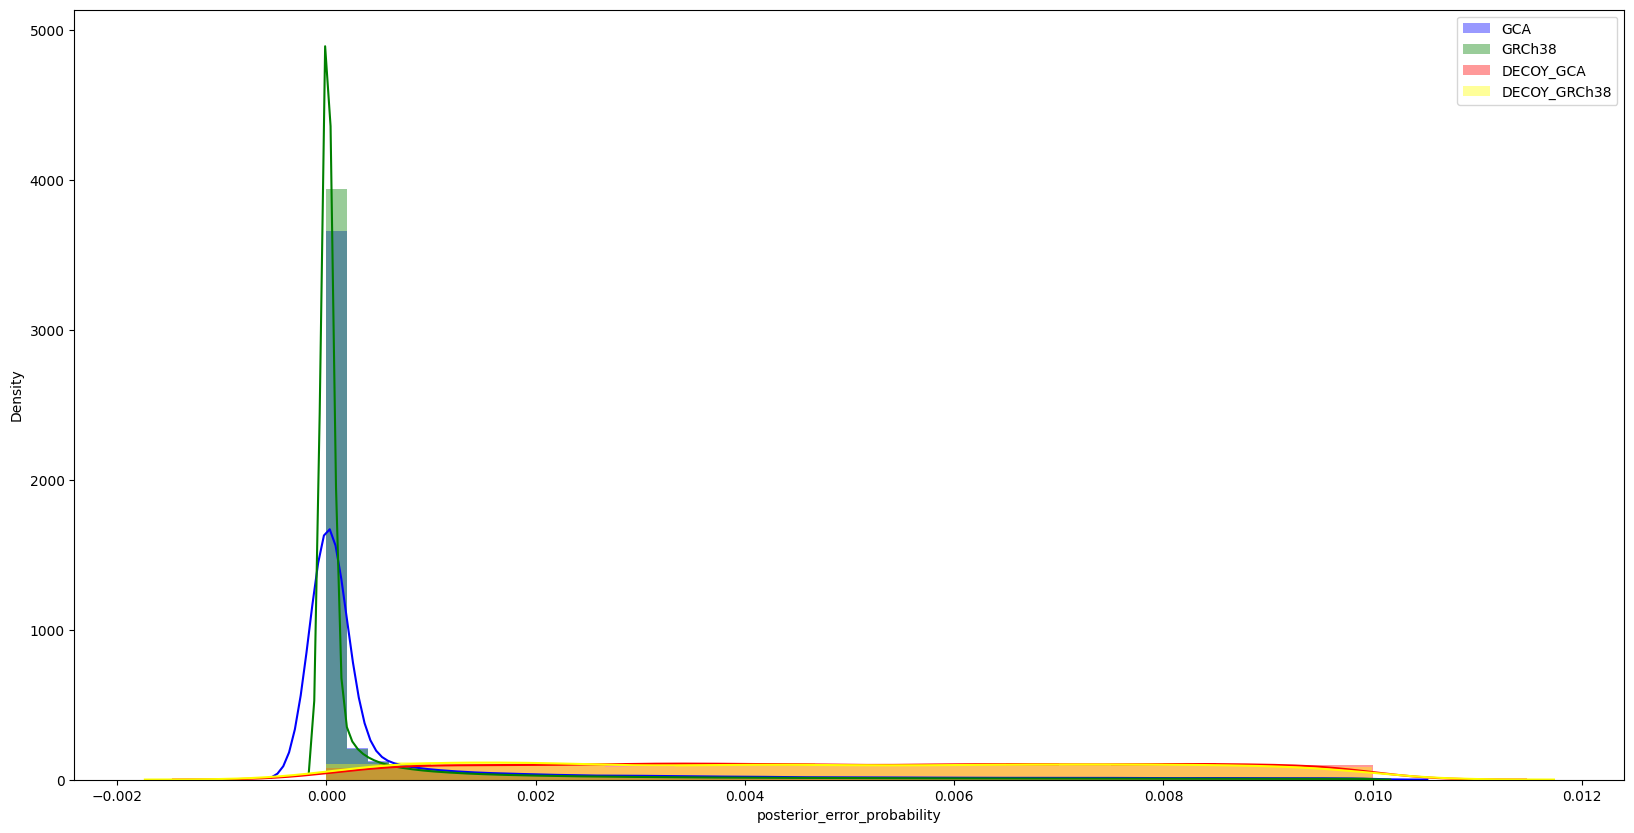

In [25]:
df2 = original_df[original_df['posterior_error_probability']<0.01]

gca = df2.loc[df2.prot_source.str.startswith("GCA")==True]
grch = df2.loc[df2.prot_source.str.startswith("GRCh38")==True]
decoy_grch = df2.loc[df2.prot_source.str.startswith("DECOY_GRCh38")==True]
decoy_gca = df2.loc[df2.prot_source.str.startswith("DECOY_GCA")==True]

#sns.df['posterior_error_probability']

plt.figure(figsize=(20, 10))
sns.distplot(gca['posterior_error_probability'], 
             hist=True, kde=True, label='GCA', color='blue')
sns.distplot(grch['posterior_error_probability'], 
             hist=True, kde=True, label='GRCh38', color='green')
sns.distplot(decoy_gca['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GCA', color='red')
sns.distplot(decoy_grch['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GRCh38', color='yellow')

plt.legend()

/var/folders/r_/b2xtff5d3j3c3tn51td6lxwx19cbq9/T/ipykernel_43499/795821690.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'GRCh38'),
  Text(1, 0, 'CONTAMINANT'),
  Text(2, 0, 'GCA'),
  Text(3, 0, 'DECOY_GCA'),
  Text(4, 0, 'DECOY_GRCh38'),
  Text(5, 0, 'DECOY_CONTAMINANT')])

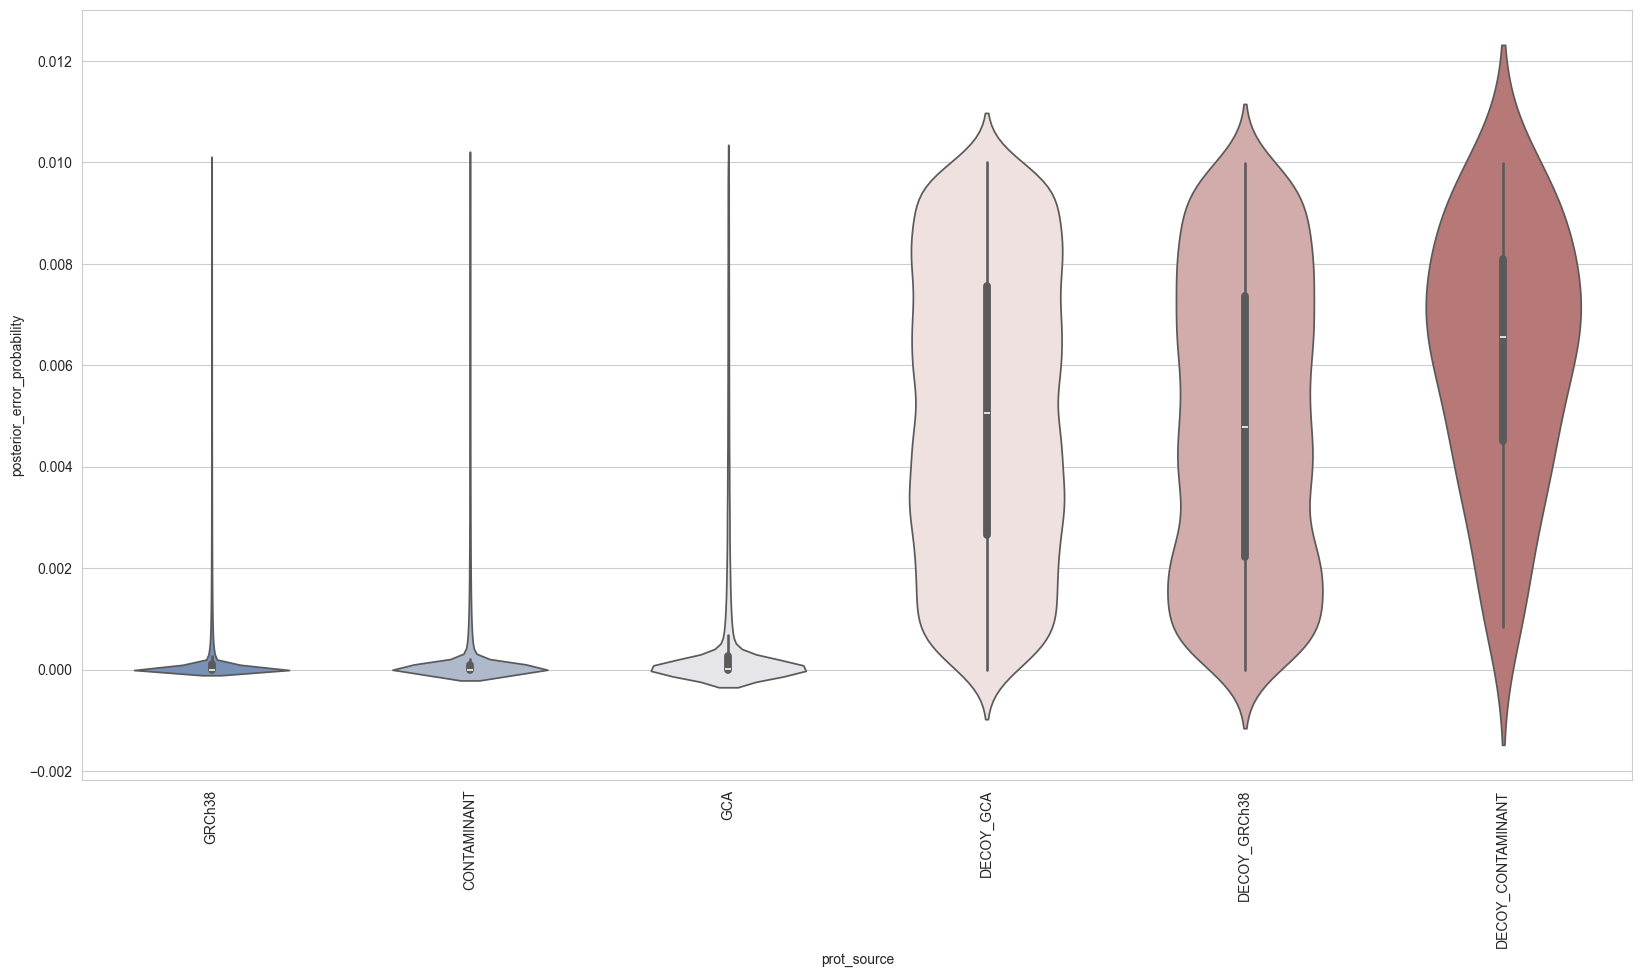

In [26]:
plt.figure(figsize=(20, 10))

sns.set_style("whitegrid")

sns.violinplot(
    data=df2, x="prot_source", y="posterior_error_probability", fill="prot_source",
    width=.6, palette="vlag"
)
plt.xticks(rotation=90) 

In [27]:
original_df[original_df['posterior_error_probability']<0.01]['prot_source'].value_counts()

prot_source
GRCh38               13696791
CONTAMINANT            542514
GCA                    128909
DECOY_GCA                6711
DECOY_GRCh38             3148
DECOY_CONTAMINANT          46
Name: count, dtype: int64

In [28]:
print('Number of unique peptide sequences from\n GCA: {}\n canonical: {}'.format(len(gca.sequence.unique()), len(grch.sequence.unique())))
print('union', len(set(grch.sequence).union(set(gca.sequence))))
print('intesect', len(set(grch.sequence).intersection(set(gca.sequence))))

Number of unique peptide sequences from
 GCA: 7141
 canonical: 340915
union 348056
intesect 0


In [29]:
def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [30]:
gca_seqs = list(set([rep(x) for x in gca['sequence'].tolist()]))

In [31]:
len(gca_seqs)

7141

#### To DeepLC

In [35]:
mod_rep = {"UNIMOD:4":"Carbamidomethyl","UNIMOD:7":"Deamidated","UNIMOD:35":"Oxidation","UNIMOD:1":"Acetyl"}
def replace_mod(x):
    s = ""
    for mod in x:
        nums = mod.split("-")[0]
        m = mod.split("-")[1]
        for n in nums.split("|"):
            if s:
                s += "|"
            s += n + "|" + mod_rep.get(m)
    return s

# convert modifications and add the rt and sequence fields
gca.loc[:,"seq"] = gca.apply(lambda x : x["sequence"],axis = 1)
gca.loc[:,"modifications"] = gca.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
gca.loc[:,"tr"] = gca.apply(lambda x : x["retention_time"],axis = 1)

grch.loc[:,"seq"] = grch.apply(lambda x : x["sequence"],axis = 1)
grch.loc[:,"modifications"] = grch.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
grch.loc[:,"tr"] = grch.apply(lambda x : x["retention_time"],axis = 1)

gca.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
grch.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
gca['modifications'] = gca['modifications'].fillna("")
grch['modifications'] = grch['modifications'].fillna("")

gca["tr"] = gca["retention_time"] 
grch["tr"] = grch["retention_time"]


/var/folders/r_/b2xtff5d3j3c3tn51td6lxwx19cbq9/T/ipykernel_43499/2847083488.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grch.loc[:,"seq"] = grch.apply(lambda x : x["sequence"],axis = 1)
/var/folders/r_/b2xtff5d3j3c3tn51td6lxwx19cbq9/T/ipykernel_43499/2847083488.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grch.loc[:,"tr"] = grch.apply(lambda x : x["retention_time"],axis = 1)
/var/folders/r_/b2xtff5d3j3c3tn51td6lxwx19cbq9/T/ipykernel_43499/2847083488.py:22: SettingWithCopyWarning: 
A value i

In [36]:
def extract_keys_values(id_scores):
    # Split each pair by colon and create a dictionary
    key_value_dict = {}
    for kv in id_scores:
       if kv is None:
          print("The score is None")
       else:
          score_string = kv.split(":")
          if len(score_string) == 2:
            key_value_dict[score_string[0]] = score_string[1]
          elif len(score_string) > 2:
            key_value_dict[":".join(score_string[:-1])] = score_string[-1]
          else:
            print.warning("The score is not in the right format score: value")
    return pd.Series(key_value_dict)  

In [37]:
# Apply the function to create new columns
sdrf_dic = sdrf.set_index('reference_file_name').to_dict()['sample_id']

In [45]:
new_columns = grch.apply(lambda x: extract_keys_values(x["id_scores"]), axis=1)

# Concatenate the new columns with the original DataFrame
grch_deeplc = pd.concat([grch[['seq', 'tr', 'modifications', 'reference_file_name']], new_columns], axis=1)
grch_deeplc = pd.merge(grch_deeplc, sdrf, on=['reference_file_name'], how='left')
grch_deeplc

,seq,tr,modifications,reference_file_name,'OpenMS:Target-decoy PSM q-value',Posterior error probability,sample_id
0,KVADALTNAVAHVDDMPNALSALSDLHAHK,4640.3813,8|Deamidated|18|Deamidated,01524_A01_P015424_S00_N01_R1,0.0005578761492428136,0.00798498,PXD010154-V122
1,KVADALTNAVAHVDDMPNALSALSDLHAHK,4303.0024,16|Oxidation|18|Deamidated,01524_A01_P015424_S00_N01_R1,0.0003700728210361938,0.00517722,PXD010154-V122
2,SLLSLPLVGSLPFLPR,6315.2000,,01524_A01_P015424_S00_N01_R1,0.0003797938467218985,0.005332789999999998,PXD010154-V122
3,VGETAPPNAYTVTDLVEYSIVIQQLSNGK,6285.5000,,01524_A01_P015424_S00_N01_R1,7.007196864639233e-06,8.30296e-05,PXD010154-V122
4,STAAMSTYTGIFTDQVLSVLK,6281.9000,,01524_A01_P015424_S00_N01_R1,0.0001862695549369511,0.00252278,PXD010154-V122
...,...,...,...,...,...,...,...
649165,IVQDIFNYIYSMDENLEFHIK,5647.6000,3|Deamidated|7|Deamidated|12|Oxidation,01306_D05_P013385_S00_N36_R1,0.0002595965423618927,0.00357767,PXD010154-V196
649166,WLLQSGIVILLPHGYDGAGPDHSSCR,5168.2000,25|Carbamidomethyl,01306_D05_P013385_S00_N36_R1,0.0004296503857328674,0.00608959,PXD010154-V196
649167,WGVFDEYNEDQPFYR,4380.8220,,01293_D05_P013196_S00_N36_R1,5.7928041400785e-06,5.95272e-05,PXD010154-V176
649168,LVNLYGLLHGLQAAVAQQDTLMEAR,5950.1396,3|Deamidated|17|Deamidated|22|Oxidation,01293_D05_P013196_S00_N36_R1,0.0002783989196250329,0.00382627,PXD010154-V176


In [46]:
new_columns = gca.apply(lambda x: extract_keys_values(x["id_scores"]), axis=1)

# Concatenate the new columns with the original DataFrame
gca_deeplc = pd.concat([gca[['seq', 'tr', 'modifications', 'reference_file_name']], new_columns], axis=1)
gca_deeplc = pd.merge(gca_deeplc, sdrf, on=['reference_file_name'], how='left')
gca_deeplc

,seq,tr,modifications,reference_file_name,'OpenMS:Target-decoy PSM q-value',Posterior error probability,sample_id
0,SVLRPSQFGGQPCTEPLVAFQPCIPSK,4390.1000,13|Carbamidomethyl|23|Carbamidomethyl,01524_A01_P015424_S00_N01_R1,2.65999930840018e-06,1.02899e-07,PXD010154-V122
1,NHSVAESLNYVASWNMSMLQTQDLVK,5243.2000,1|Deamidated|15|Deamidated|16|Oxidation,01524_A01_P015424_S00_N01_R1,2.65999930840018e-06,8.999940000000002e-09,PXD010154-V122
2,QSGGSSQAGAVTVSDVQELMR,4081.7000,,01524_A01_P015424_S00_N01_R1,2.65999930840018e-06,2.99883e-08,PXD010154-V122
3,LGMIVDKIDVDKDGFVTEGELK,4128.1000,,01524_A01_P015424_S00_N01_R1,2.692984799080076e-06,5.220950000000001e-06,PXD010154-V122
4,SLPEETVDFMVQHTSFK,4693.2000,,01524_A01_P015424_S00_N01_R1,2.65999930840018e-06,9.63489e-07,PXD010154-V122
...,...,...,...,...,...,...,...
13638,GILTLKYPMEHGITNWDDMEK,3791.0474,9|Oxidation,01350_D05_P013681_S00_N36_R1,0.000155872720172485,0.00209935,PXD010154-V321
13639,GCSMSLWDLLLSEYVGADK,5890.8000,2|Carbamidomethyl,01501_D05_P015161_S00_N36_R1,6.385924279141141e-06,7.59474e-05,PXD010154-V240
13640,CLLAATSPGAAEPAGVGTITCLVTGFSPADVFVQWMQR,5537.5840,1|Carbamidomethyl|21|Carbamidomethyl|36|Oxidation,01284_D05_P013188_B00_N36_R1,0.000658914428537713,0.009522770000000002,PXD010154-V151
13641,PPQQQQQQQQQQQQQQASATGSSQPAAESSTQQR,2821.5000,4|Deamidated|8|Deamidated|9|Deamidated,01087_D05_P010739_S00_N36_R1,2.692984799080076e-06,1.56052e-06,PXD010154-V296


In [47]:
# Save to files for DeepLC 
gca_deeplc.to_csv('gca_peptides_for_deeplc.csv', index=False)
grch_deeplc.to_csv('grch_peptides_for_deeplc.csv', index=False)
